In [1]:
# coding: utf-8
# 增加了test数据集

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import numpy as np

print(torch.__version__)

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# 参数
learning_rate = 0.01
momentum = 0.9
epochs = 10
batch_size = 30
display_step = 1
num_classes = 45

# 加载模型

In [2]:
# 加载vgg13预训练模型
model = models.vgg13(pretrained=False)
model.classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, num_classes))
# 使用多块GPU
# model = nn.DataParallel(model)
# model.load_state_dict(torch.load('./parameter/ash_sand_1_16_vgg13_params.pth'))

# 数据集准备

In [73]:
# crop:裁剪 resize:缩放 flip:翻转
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.396, 0.434, 0.435], [0.055, 0.053, 0.054])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.396, 0.434, 0.435], [0.055, 0.053, 0.054])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.396, 0.434, 0.435], [0.055, 0.053, 0.054])
    ]),
}

# your image data file
data_dir = './images_paste/images_ash_sand_1_16/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'validation', 'test']}
# torchvision.datasets.ImageFolder返回的是list，这里用torch.utils.data.DataLoader类将list类型的输入数据封装成Tensor数据格式
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size = batch_size,
                                             shuffle = True,
                                             num_workers = 50) for x in ['train', 'validation', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# 使用GPU，定义相关函数

In [5]:
# 是否使用GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

print("use_gpu: " + str(use_gpu))
    
# 定义损失函数，这里采用交叉熵函数
loss_fn = nn.CrossEntropyLoss()

# 定义优化函数，这里采用随机梯度下降法
optimizer = optim.SGD(model.parameters(), learning_rate, momentum)

# 定义学习率的变化策略，这里采用torch.optim.lr_scheduler模块的StepLR类，表示每隔step_size个epoch就将学习率降为原来的gamma倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

use_gpu: True


# 定义作图函数

In [44]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
get_ipython().run_line_magic('matplotlib', 'inline')
def plot(epoch, train_loss, acc_train, loss_val, acc_val):
    clear_output(True)
    
    # 绘制第一个图，在一幅图上画两条曲线
    plt.figure()
    plt.title("epoch %s. train loss: %.10f. val loss: %.10f" % (epoch + 1, train_loss[-1], loss_val[-1]))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(1, epoch + 2, 1.0))
    plt.plot(range(1,epoch + 2), train_loss,color='r', label='train')
    plt.plot(range(1,epoch + 2), loss_val,color='b', label='validation')
    plt.legend()  # 设置图例和其中的文本的显示
    plt.savefig('./figure/ash_sand_1_16_photo_classification_vgg13_loss.png')

    # 绘制第二个图，在一幅图上画两条曲线
    plt.figure()
    plt.title("epoch %s. train acc: %.10f. val acc: %.10f" % (epoch + 1, acc_train[-1], acc_val[-1]))
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.xticks(np.arange(1, epoch + 2, 1.0))
    plt.plot(range(1,epoch + 2), acc_train,color='r', label='train')
    plt.plot(range(1,epoch + 2), acc_val,color='b', label='validation')
    plt.legend()  # 设置图例和其中的文本的显示
    plt.savefig('./figure/ash_sand_1_16_photo_classification_vgg13_acc.png')

    plt.show()

# Train

In [ ]:
since = time.time()
best_model_wts = model.state_dict()
best_acc = 0
lowest_loss = 99999
train_loss = [] # 训练集loss
acc_train = [] # 训练集正确率
loss_val = [] # 验证集loss
acc_val = [] # 验证集正确率
best_matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

f = open('./result/ash_sand_1_16_vgg13_result.txt', 'a')
for epoch in range(epochs):
    exp_lr_scheduler.step()  # 调整学习率
    print('learning_rate: {}'.format(exp_lr_scheduler.get_lr()))
    f.write('learning_rate: {}\n'.format(exp_lr_scheduler.get_lr()))
    
    if epoch % display_step == 0:
        print('Epoch [{}/{}]:'.format(epoch + 1, epochs))
        f.write('Epoch [{}/{}]:\n'.format(epoch + 1, epochs))
        
    # 每一轮都跑一遍训练集和验证集
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()  # 把module设成training模式，对Dropout和BatchNorm有影响
        else:
            model.eval()  # 把module设置为评估模式

        batch_num = 1
        running_loss = 0.0
        running_corrects = 0
        matrix = [[0 for i in range(num_classes)] for i in range(num_classes)]

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data

            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # 先将网络中的所有梯度置0
            optimizer.zero_grad()

            # 网络的前向传播
            outputs = model(inputs)

            # 计算损失
            loss = loss_fn(outputs, labels)

            # 得到模型预测该样本属于哪个类别的信息
            _, preds = torch.max(outputs.data, 1)

            # 训练时，应用回传和优化
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # 记录当前batch_size的loss以及数据对应的分类准确数量
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            if phase == 'validation':
                for k in range(0, batch_size):
                    matrix[labels.data.cpu().numpy()[k]][preds.cpu().numpy()[k]] += 1

            print('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch + 1, batch_num, loss.item()/batch_size, 1.0*torch.sum(preds == labels.data).item()/batch_size*100))
            f.write('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%\n'.format(phase, epoch + 1, batch_num, loss.item()/batch_size, 1.0*torch.sum(preds == labels.data).item()/batch_size*100))
            batch_num = batch_num + 1

        # 计算并打印这一轮训练的loss和分类准确率
        if phase == 'train':
            epoch_loss_train = running_loss / dataset_sizes['train']
            epoch_acc_train = running_corrects.item() / dataset_sizes['train']
            loss_train.append(epoch_loss_train)
            acc_train.append(epoch_acc_train)            
        else:
            epoch_loss_val = running_loss / dataset_sizes['validation']
            epoch_acc_val = running_corrects.item() / dataset_sizes['validation']
            loss_val.append(epoch_loss_val)
            acc_val.append(epoch_acc_val)

        if epoch % display_step == 0 and phase == 'validation':
            # 动态作图
            plot(epoch, loss_train, acc_train, loss_val, acc_val)
            
            # 保存结果
            print('\ttrain Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_train, epoch_acc_train*100))
            f.write('\ttrain Loss: {:.4f} Acc: {:.4f}%\n'.format(epoch_loss_train, epoch_acc_train*100))
            print('\tvalidation Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_val, epoch_acc_val*100))
            f.write('\tvalidation Loss: {:.4f} Acc: {:.4f}%\n'.format(epoch_loss_val, epoch_acc_val*100))

        # 保存验证集loss最低的模型参数
        if phase == 'validation' and epoch_loss_val < lowest_loss:
            lowest_loss = epoch_loss_val
            best_acc = epoch_acc_val
            best_model_wts = model.state_dict()
            print("Network parameter update.")
            f.write("Network parameter update.\n")
            # 保存最优参数
            torch.save(best_model_wts, './parameter/ash_sand_1_16_vgg13_params.pth')
            best_matrix = copy.deepcopy(matrix)
    time_elapsed = time.time() - since
    print('Time passed {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    print('-' * 20)
    f.write('Time passed {:.0f}h {:.0f}m {:.0f}s\n'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    f.write('-' * 20 + "\n")

# 计算训练所耗时间
time_elapsed = time.time() - since
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))
f.write('Training complete in {:.0f}h {:.0f}m {:.0f}s\n'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
f.write('Best validation Acc: {:4f}\n'.format(best_acc))
f.close()

#  保存混淆矩阵为excel

In [8]:
from openpyxl import Workbook # xlsx

def save(data, path):
    # xlsx
    workbook = Workbook()
    booksheet = workbook.active  # 获取当前活跃的sheet,默认是第一个sheet
    h = len(data) # 行数
    l = len(data[0]) #列数
    for i in range(h):
        for j in range(l):
            booksheet.cell(i+1, j+1).value = data[i][j]
    workbook.save(path)

save(best_matrix,'./result/ash_sand_1_16_vgg13_confusion_matrix.xlsx')

# Test

In [ ]:
# 开始测试
since = time.time()
model.eval()
number = 0
matrix2 = [[0 for i in range(1000)] for i in range(num_classes)]  # 记录每张图片的预测结果

# Iterate over data.
for data in dataloders_test:
    # get the inputs
    inputs, labels = data

    # PyTorch更新至0.4.0后，将Variable和Tensor合并
    if use_gpu:
        inputs = inputs.cuda()
        labels = labels.cuda()

    # 先将网络中的所有梯度置0
    optimizer.zero_grad()

    # 网络的前向传播
    outputs = model(inputs)

    # 计算损失
    loss = loss_fn(outputs, labels)

    # 得到模型预测该样本属于哪个类别的信息
    _, preds = torch.max(outputs.data, 1)
    for k in range(batch_size):
        matrix2[labels.data.cpu().numpy()[k]][number] = preds.cpu().numpy()[k]
        number += 1
        if number == 1000:
            number = 0

time_elapsed = time.time() - since
print('Test complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))

# 创建浓度矩阵

In [70]:
concentration = []  # 浓度标签矩阵
density = 200
while True:
    concentration.append(density)
    if density == 780:
        break
    if density < 600:
        density += 50
    else:
        density += 5
print(concentration)

[200, 250, 300, 350, 400, 450, 500, 550, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780]


In [71]:
print(len(concentration))

45


测试集正确率：0.9159111111


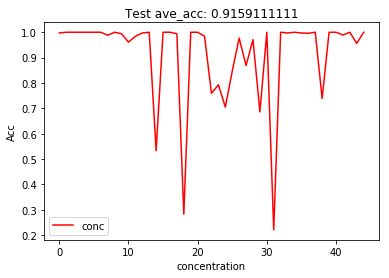

In [76]:
# conc 浓度

def plot_test(ave_acc, conc_acc):
    plt.figure()
    plt.title("Test ave_acc: %.10f" % ave_acc)
    plt.xlabel("concentration")
    plt.ylabel("Acc")
    plt.plot(conc_acc,color='r', label='conc')
    plt.legend()  # 设置图例和其中的文本的显示

matrix_conc = [[0 for i in range(1000)] for i in range(num_classes)]
conc_acc = []  # 记录各个浓度的正确率
acc_count = 0  # 总共预测正确数量

# 将matrix2中的数字标签转换为浓度
for x in range(num_classes):
    for y in range(1000):
        matrix_conc[x][y] = concentration[matrix2[x][y]]  # matrix2:0-44; concentration:200-780

for label in range(num_classes):
    count = 0  # 各个浓度的预测正确数量
    for k in range(1000):
        if matrix2[label][k] == label:
            count += 1
            acc_count += 1
    conc_acc.append(count/1000)  # 加入当前浓度的正确率
    var = np.var(matrix_conc[label])  # 方差

ave_acc = acc_count/len(image_datasets['test'])
print("测试集正确率：%.10f" % ave_acc)
plot_test(ave_acc, conc_acc)

# 方差

In [14]:
var_sum = 0
for label in range(num_classes):
    var_sum += np.var(matrix_conc[label])
var_ave = var_sum / num_classes
print("平均方差：" + str(var_ave))

平均方差：25.32571611111111


In [16]:
# 75%-78%浓度方差
var_sum2 = 0
for label in range(38, 45):
    var_sum2 += np.var(matrix_conc[label])
var_ave2 = var_sum2 / num_classes
print("75%-78%浓度平均方差：" + str(var_ave2))

75%-78%浓度平均方差：0.7968472222222223


# 查看波动性

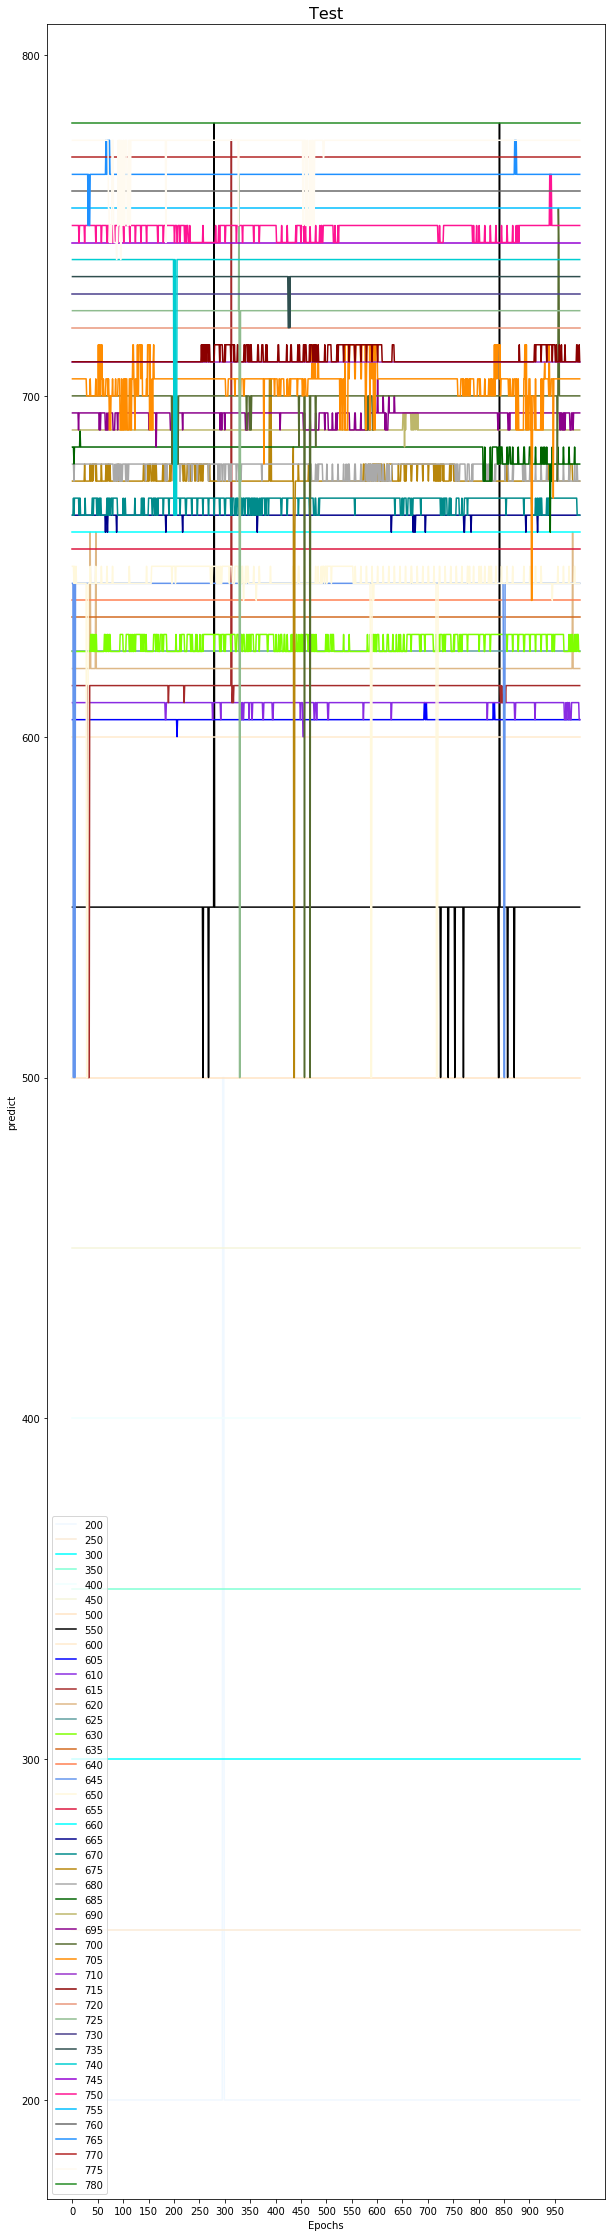

In [18]:
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

colors = ['#F0F8FF', '#FAEBD7', '#00FFFF', '#7FFFD4', '#F0FFFF', '#F5F5DC', '#FFE4C4', '#000000', '#FFEBCD', '#0000FF', '#8A2BE2', '#A52A2A', '#DEB887', '#5F9EA0', '#7FFF00', '#D2691E', '#FF7F50', '#6495ED', '#FFF8DC', '#DC143C', '#00FFFF', '#00008B', '#008B8B', '#B8860B', '#A9A9A9', '#006400', '#BDB76B', '#8B008B', '#556B2F', '#FF8C00', '#9932CC', '#8B0000', '#E9967A', '#8FBC8F', '#483D8B', '#2F4F4F', '#00CED1', '#9400D3', '#FF1493', '#00BFFF', '#696969', '#1E90FF', '#B22222', '#FFFAF0', '#228B22']

plt.figure(figsize=(10,40))
plt.title('Test',fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("predict")
plt.xticks(np.arange(0, 1000, 50))
for label in range(num_classes):
    plt.plot(range(1000), matrix_conc[label],color=colors[label], label=str(concentration[label]))
    plt.legend()  # 设置图例和其中的文本的显示

plt.show()